# <center>Variational autoencoder</center>

In [1]:
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torchsummary import summary
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}.')

Device: cuda.


## Datos de entrenamiento

In [2]:
dataset = datasets.CIFAR10('data', train=True, transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(f'Dataset length: {len(dataset)} samples.')

Files already downloaded and verified
Dataset length: 50000 samples.


In [3]:
def show_batch(images: torch.tensor, fig_filename=None):
    nrow = int(len(images) ** (1/2))
    grid_tensor = utils.make_grid(images, nrow=nrow).cpu()
    plt.axis('off')
    plt.imshow(grid_tensor.permute(1, 2, 0))
    if fig_filename is not None:
        plt.savefig(f'images/dm/{fig_filename}.pdf', bbox_inches='tight')
    plt.show()

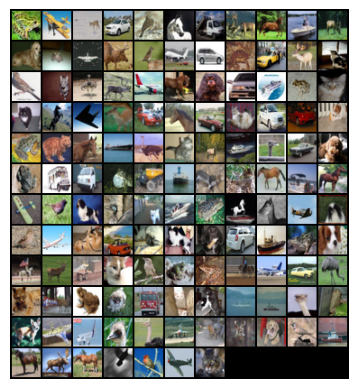

In [4]:
x, _ = next(iter(dataloader))
show_batch(x)

## VAE

### Red neuronal

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_size: list, inner_channels: list = [32, 64, 128, 256, 512], latent_size: int = 256):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        channels, width, height = input_size
        chs_list = [channels] + inner_channels

        # Encoder:
        encoder_blocks = [self.conv_block(chs_list[i], chs_list[i+1]) for i in range(len(chs_list) - 1)]
        self.encoder = nn.Sequential(*encoder_blocks, nn.Flatten())

        # Latent projections:
        reduction_factor = 2 ** len(inner_channels)
        hidden_width, hidden_height = width // reduction_factor, height // reduction_factor
        hidden_size = chs_list[-1] * hidden_width * hidden_height

        self.mu_layer = nn.Linear(hidden_size, latent_size)
        self.logvar_layer = nn.Linear(hidden_size, latent_size)

        # Decoder:
        decoder_blocks = [self.deconv_block(chs_list[-i], chs_list[-i-1], activation = (i != len(inner_channels))) for i in range(1, len(chs_list))]
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Unflatten(1, (chs_list[-1], hidden_width, hidden_height)),
            *decoder_blocks,
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> tuple:
        encoding = self.encoder(x)
        mu = self.mu_layer(encoding)
        logvar = self.logvar_layer(encoding)
        z = mu + torch.exp(logvar / 2) * torch.randn_like(mu)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

    @staticmethod
    def conv_block(in_channels: int, out_channels: int, activation: bool = True) -> nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if activation else nn.Identity(),
        )

    @staticmethod
    def deconv_block(in_channels: int, out_channels: int, activation: bool = True) -> nn.Module:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if activation else nn.Identity(),
        )

### Entrenamiento

In [6]:
def loss_function(model: nn.Module, input: torch.Tensor) -> torch.Tensor:
    x_hat, mu, logvar = model(input)
    reconstruction_term = nn.BCELoss(reduction='sum')(x_hat, input)
    kl_divergence_term = -1/2 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())
    return (reconstruction_term + kl_divergence_term) / input.size(0)

In [7]:
def train_vae(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader, epochs: int) -> None:

    model.to(device).train()

    progressbar = tqdm.trange(epochs)

    try:
        for epoch in progressbar:
            epoch_loss = 0

            for x, _ in dataloader:
                loss = loss_function(model, x.to(device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            epoch_loss /= len(dataloader)
            progressbar.set_postfix(epoch_loss=epoch_loss)

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

## VAE en CIFAR-10

### Red neuronal y entrenamiento

In [8]:
input_size = dataset[0][0].shape
model = VAE(input_size).to(device)

summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              ReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              ReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
             ReLU-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 512, 1, 1]       1,180,160
      BatchNorm2d-14            [-1, 51

In [9]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_vae(model, optimizer, dataloader, epochs=50)

100%|██████████| 50/50 [14:04<00:00, 16.89s/it, epoch_loss=1.82e+3]


### Test de reconstrucción

In [10]:
def reconstruction(model: nn.Module, input: torch.Tensor) -> None:
    model.to(device).eval()
    output, _, _ = model(input.to(device))
    images = torch.cat([input, output.cpu()], dim=0)
    show_batch(images, fig_filename='vae_reconstruction')

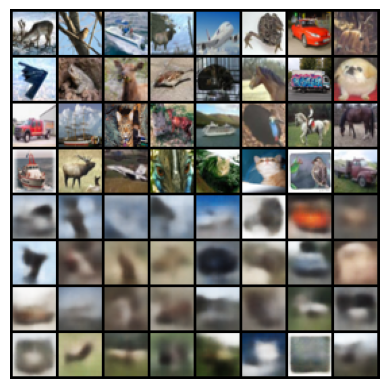

In [11]:
x, _ = next(iter(dataloader))
reconstruction(model, x[:32])

### Generación de muestras

In [12]:
def generate_samples(model, n_samples):
    z = torch.randn(n_samples, model.latent_size, device=device)
    images = model.decoder(z)
    show_batch(images, fig_filename='vae_samples')

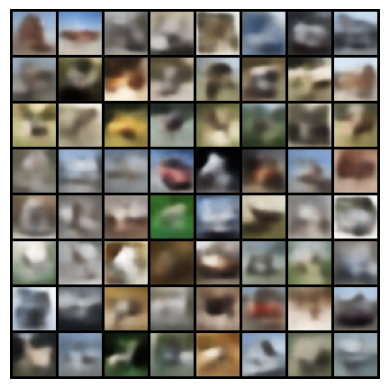

In [13]:
generate_samples(model, 64)